# Sourcing & Analyzing Time Series Data

## Table of Contents:

### 1. Importing Libraries & Data

### 2. Subsetting, Wrangling, & Cleaning Time-Series Data

### 3. Time Series Analysis: Decomposition

### 4. Testing for Stationarity

### 5. Stationarizing the Dataset

### 6. Notes About the Data

## 1. Importing Libraries & Data

In [66]:
# Using .api to import public access version of statsmodels, a library that handles statistical models
# Using last library to handle warnings

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings 

# Disabling deprecation warnings that could indicate, for instance, a suspended library or feature; not task-relevant

warnings.filterwarnings("ignore") 

# Choosing styling option for how plots will appear

plt.style.use('fivethirtyeight')

In [80]:
# Configure API key 

quandl.ApiConfig.api_key = 'QcnqCcUBFc-xjM6wAAsG'

In [81]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('RATEINF/CPI_AUS')

In [82]:
data.head(5)

,Value
Date,
1948-09-30,3.7
1948-12-31,3.8
1949-03-31,3.9
1949-06-30,4.0
1949-09-30,4.1


In [83]:
data.shape

(298, 1)

In [85]:
data.columns

Index(['Value'], dtype='object')

In [86]:
type(data)

pandas.core.frame.DataFrame

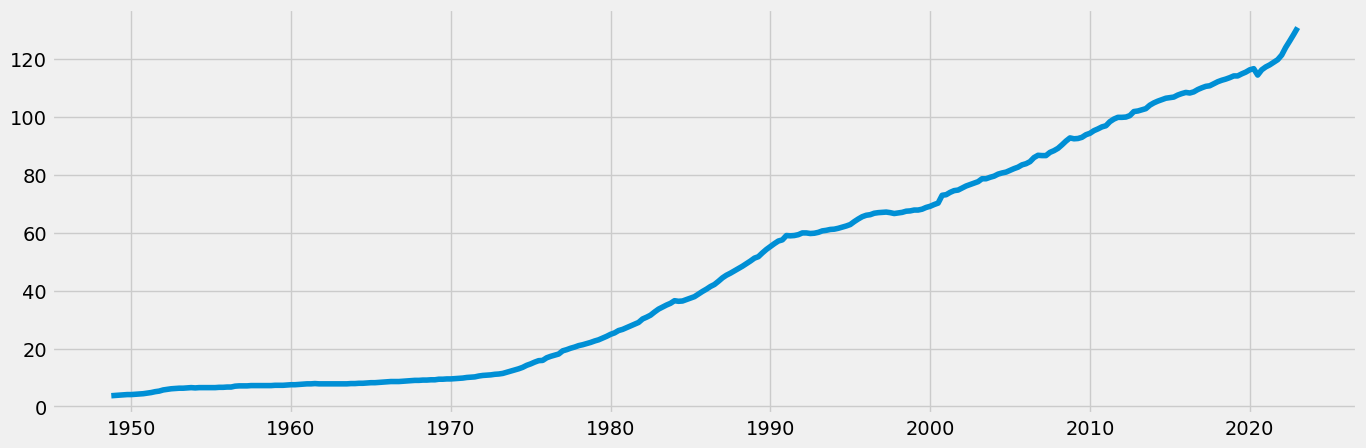

In [87]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## 2. Subsetting, Wrangling, & Cleaning Time-Series Data

In [88]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [89]:
data_2.head()

,Date,Value
0,1948-09-30,3.7
1,1948-12-31,3.8
2,1949-03-31,3.9
3,1949-06-30,4.0
4,1949-09-30,4.1


In [90]:
data_sub = data_2.loc[(data_2['Date'] >= '1970-01-01') & (data_2['Date'] < '2020-06-01')]

In [92]:
data_sub.shape

(201, 2)

In [93]:
data_sub.head()

,Date,Value
86,1970-03-31,9.6
87,1970-06-30,9.7
88,1970-09-30,9.8
89,1970-12-31,10.0
90,1971-03-31,10.1


<B>I selected this subset because when looking at the data, 1970 was the year the price index started to increase, so only upward trending data would be included in the analysis

In [94]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1970-03-31,9.6
1970-06-30,9.7
1970-09-30,9.8
1970-12-31,10.0
1971-03-31,10.1


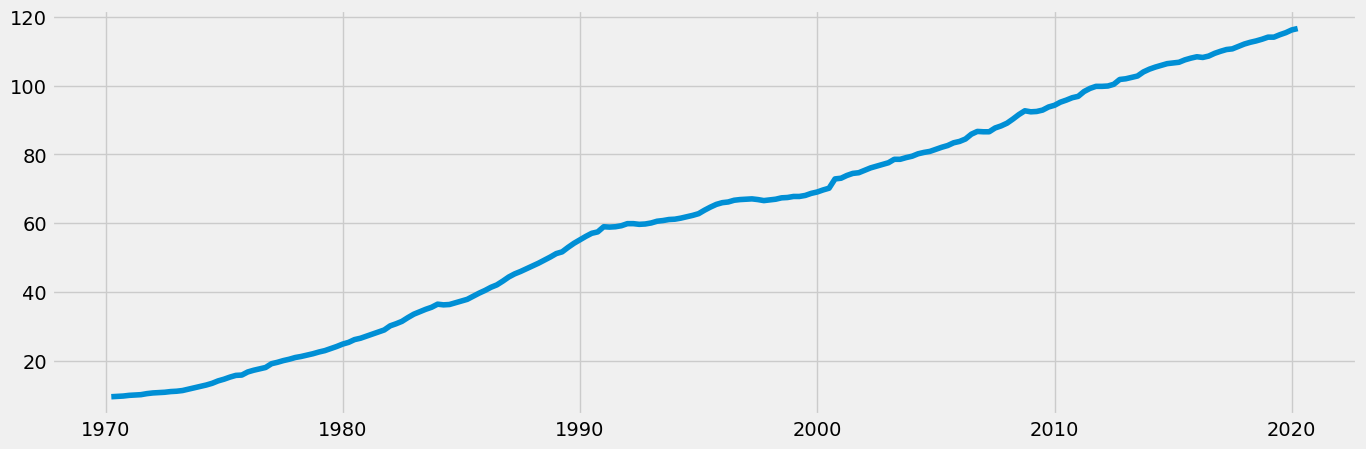

In [95]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [96]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [97]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

9

## 3. Time Series Analysis: Decomposition

In [98]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [99]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

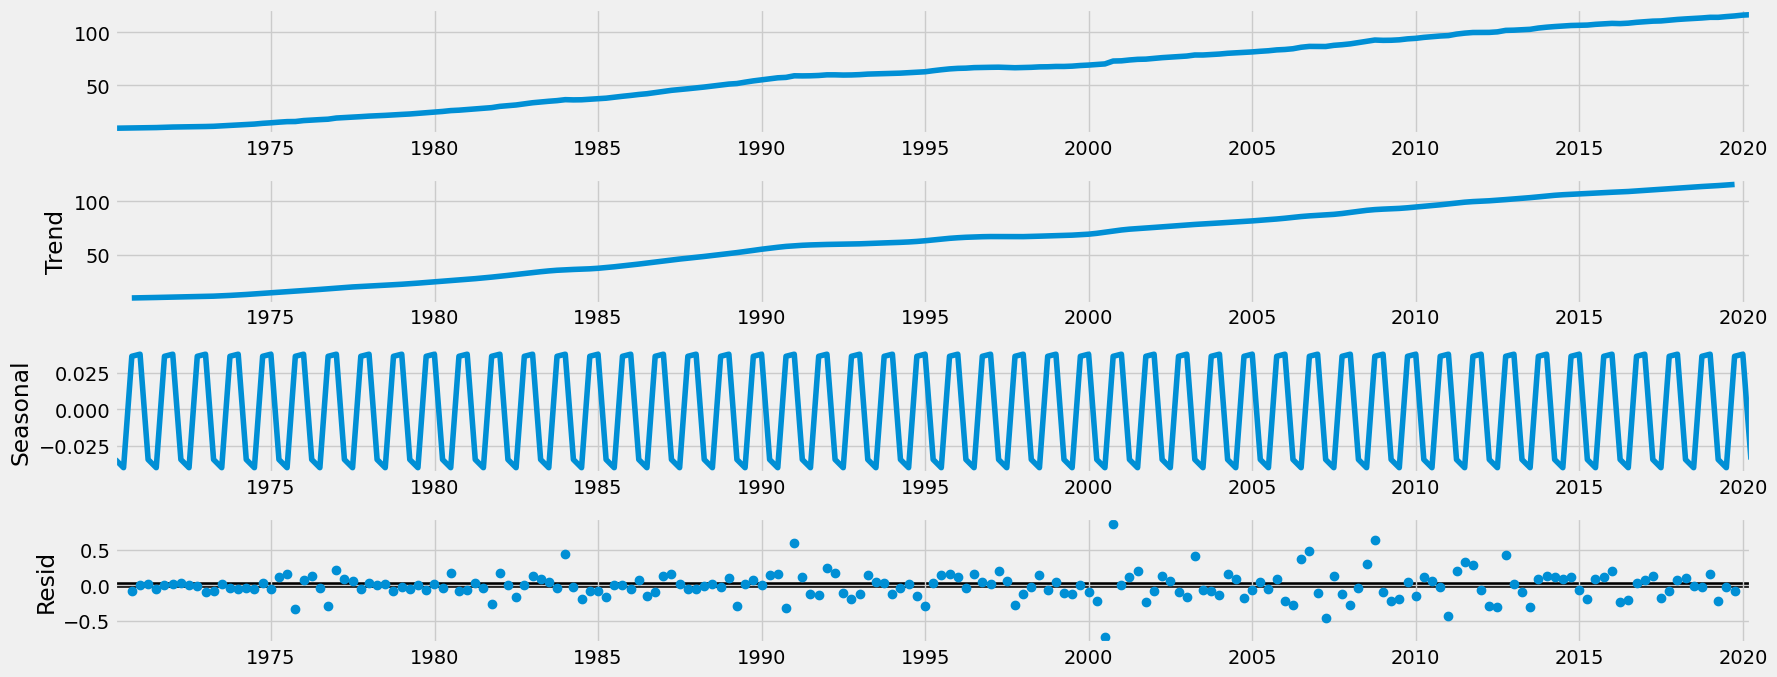

In [100]:
# Plot the separate components

decomposition.plot()
plt.show()

<B>The decomposition shows that the price index started to take off in 1970 and continued to rise all the way through 2020, indicting a steady rise in consumer goods and services over that time period. The seasonality trend is spiking in regular intervals, indicating that seasonal fluctuations are present. The residual graph at the bottom is consistent with the original data.

## 4. Testing for Stationarity

In [101]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.108857
p-value                          0.948549
Number of Lags Used              4.000000
Number of Observations Used    196.000000
Critical Value (1%)             -3.464161
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
dtype: float64


<B>The test statistic of -0.10 is larger than the critical value (5%) of -2.87, so the null hypothesis cannot be rejected. Additionally, the p-value is 0.95, higher than the value of significance of 0.05, meaning the result is not significant. 

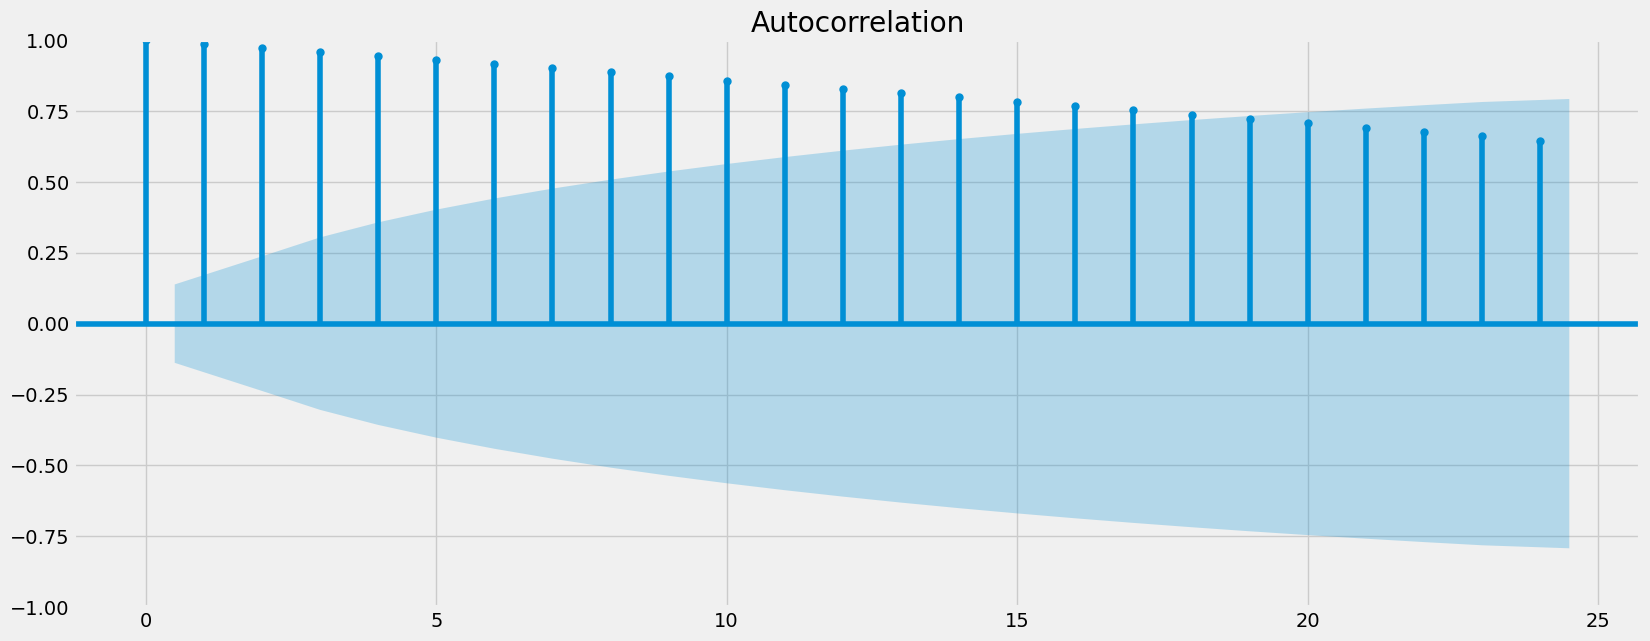

In [102]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

<B>The test shows above half of vertical lines are outside of the confidence interval, meaning that there are significantly correlated lags in the data. This also means the data is not stationary.

## 5. Stationarizing the Dataset

In [103]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [104]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [105]:
data_diff.head()

,Value
datetime,
1970-06-30,0.1
1970-09-30,0.1
1970-12-31,0.2
1971-03-31,0.1
1971-06-30,0.1


In [106]:
data_diff.columns

Index(['Value'], dtype='object')

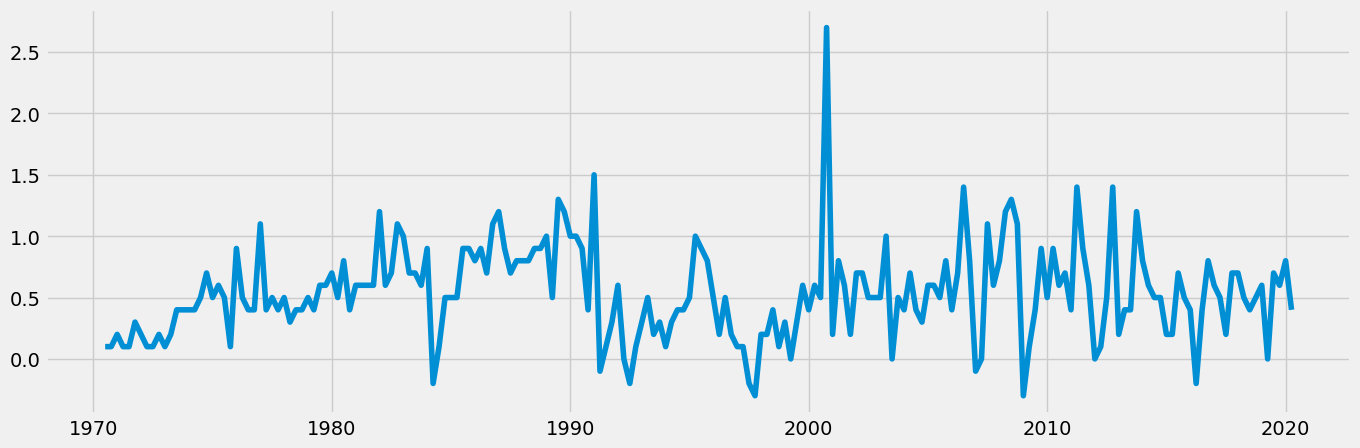

In [107]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [108]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.682388
p-value                          0.000091
Number of Lags Used              3.000000
Number of Observations Used    196.000000
Critical Value (1%)             -3.464161
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
dtype: float64


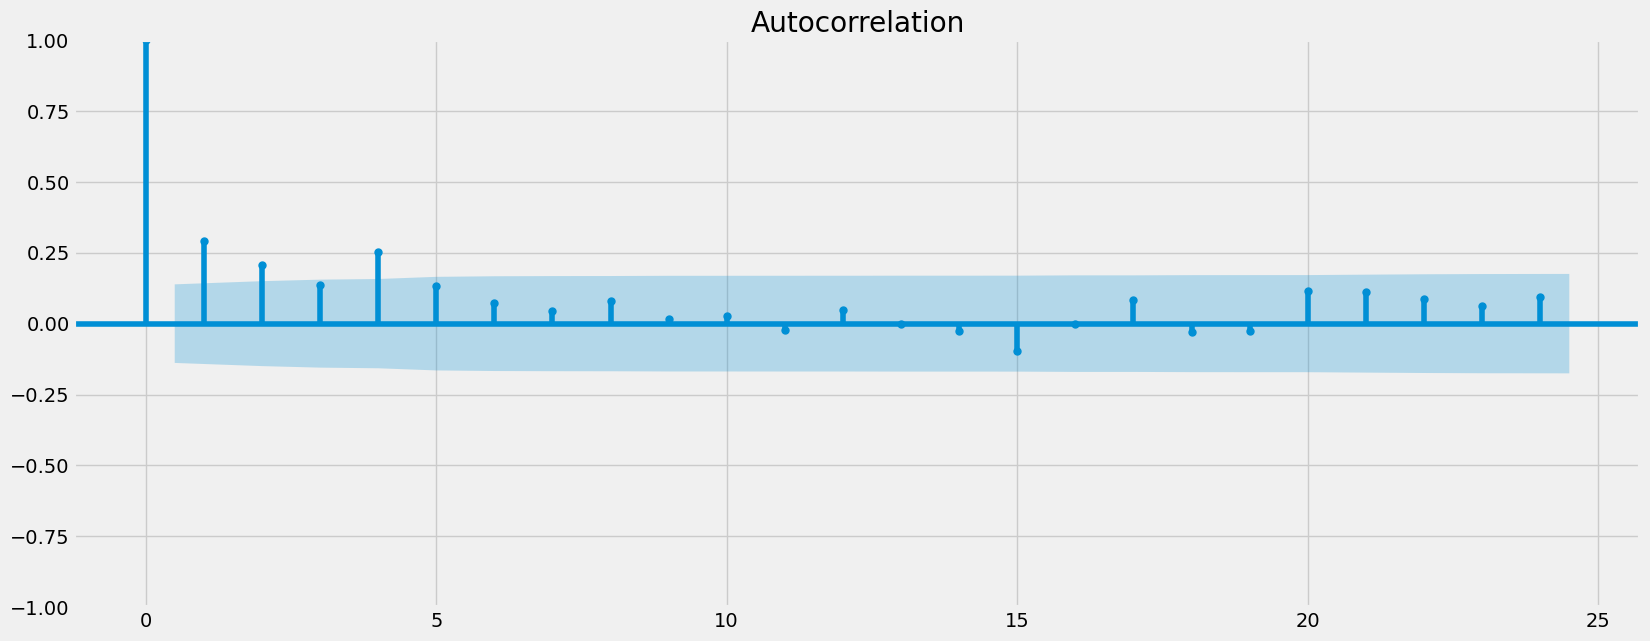

In [109]:
plot_acf(data_diff)
plt.show()

<B>The test statistic of -4.68 is now lower than the critical value (5%) of -2.88, meaning that the null hypothesis can be rejected. This is also confirmed with the new p-value of 0.00, indicating that the results are significant.

## 6. Notes About the Data

The main dataset for this project did not include time data, so I had to source a different dataset to perform the time series analysis. I picked this Quandl dataset for Australia because my original dataset showed that they had the highest quality of life for 2021 and I wanted to see if economic factors, which were not a variable in my dataset, showed any trends over time that would provide more evidence as to why Australians have a higher quality of life (in addition to the main metrics used in the rest of the analysis).